In [1]:
# Pytorch and tools
import torch as th
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from RunningEnv import EnvWrapper
from Experiments import ActorCriticExperiment
from Learners import ReinforceLearner
from Learners import OffpolicyActorCriticLearner
from Learners import PPOLearner
from Model.Experiments import ActorCriticExperimentRunning

In [2]:
pref_pace = 181
target_pace = pref_pace * 1.1

In [3]:
def default_params():
    """ These are the default parameters used int eh framework. """
    return {  # Debugging outputs and plotting during training
        'plot_frequency': 10,  # plots a debug message avery n steps
        'plot_train_samples': True,  # whether the x-axis is env.steps (True) or episodes (False)
        'print_when_plot': True,  # prints debug message if True
        'print_dots': False,  # prints dots for every gradient update
        # Environment parameters
        'env': 'CartPole-v0',  # the environment the agent is learning in
        'run_steps': 0,  # samples whole episodes if run_steps <= 0
        'max_episode_length': 500,  # maximum number of steps per episode
        # Runner parameters
        'max_episodes': int(1E6),  # experiment stops after this many episodes
        'max_batch_episodes': int(1E6),  # experiment stops after this many batch
        'max_steps': int(1E9),  # experiment stops after this many steps
        'multi_runner': False,  # uses multiple runners if True
        'parallel_environments': 4,  # number of parallel runners  (only if multi_runner==True)
        # Exploration parameters
        'epsilon_anneal_time': int(5E3),  # exploration anneals epsilon over these many steps
        'epsilon_finish': 0.1,  # annealing stops at (and keeps) this epsilon
        'epsilon_start': 1,  # annealing starts at this epsilon
        # Optimization parameters
        'lr': 1E-4,  # 5E-4,                       # learning rate of optimizer
        'gamma': 0.99,  # discount factor gamma
        'batch_size': 2048,  # number of transitions in a mini-batch
        'grad_norm_clip': 1,  # gradent clipping if grad norm is larger than this
        # DQN parameters
        'replay_buffer_size': int(1E5),  # the number of transitions in the replay buffer
        'use_last_episode': True,  # whether the last episode is always sampled from the buffer
        'target_model': True,  # whether a target model is used in DQN
        'target_update': 'soft',  # 'soft' target update or hard update by regular 'copy'
        'target_update_interval': 10,  # interval for the 'copy' target update
        'soft_target_update_param': 0.01,  # update parameter for the 'soft' target update
        'double_q': True,  # whether DQN uses double Q-learning
        'grad_repeats': 1,  # how many gradient updates / runner call
        # Image input parameters
        'pixel_observations': False,  # use pixel observations (we will not use this feature here)
        'pixel_resolution': (78, 78),  # scale image to this resoluton
        'pixel_grayscale': True,  # convert image into grayscale
        'pixel_add_last_obs': True,  # stacks 2 observations
        'pixel_last_obs_delay': 3,  # delay between the two stacked observations

        # Runners env
        'pref_pace': 181,  # Athlete's preferred pace
        'target_pace': pref_pace * 1.1,  # Athlete's target pace
        'states_shape': (1,),  # Amount of states
        'num_actions': 5,  # Possible actions
    }

In [4]:
def test_in_environment(experiment, env):
    state = env.reset()
    try_scores = []

    for _ in range(50):
        env.reset()
        state = env.step(0)[0]
        done = False
        score = 0
        while not done:
            action = experiment.controller.choose(state, increase_counter=False).detach().item()
            new_state, reward, done = env.step(action)
            score += reward
            state = new_state
        try_scores.append(score)
    print(np.array(try_scores).mean())

    # Print one episode

    env.reset()
    state = env.step(0)[0]
    done = False

    while not done:
        action = experiment.controller.choose(state, increase_counter=False).detach().item()
        new_state, reward, done = env.step(action)

        # if action == 0:
        #     print(env.steps, action)
        # if reward < 0:
        #     print(action, state, new_state, reward)
        # if (action != 5):
        # #     # print(action, (state+1)*pref_pace, (new_state+1)*pref_pace, reward)
        #     print(action, state, new_state, reward)
        state = new_state

    x = np.linspace(0, len(env.env_pacing), len(env.env_pacing))
    plt.figure()
    plt.scatter(x[np.array(env.env_pacing) == 1], np.array(env.pace)[np.array(env.env_pacing) == 1], marker="x",
                label='Paced steps')
    plt.scatter(x[np.array(env.env_pacing) == 0], np.array(env.pace)[np.array(env.env_pacing) == 0], marker="x",
                label='Not-paced steps')

    # plt.scatter(x[np.array(env_pacing)==1], np.array(pace)[np.array(env_pacing)==1], marker="x", label='Paced steps')
    # plt.scatter(x[np.array(env_pacing)==0], np.array(pace)[np.array(env_pacing)==0], marker="x", label='Not-paced steps')

    # plt.scatter(x[np.array(pacing)==1], np.array(pacing)[np.array(pacing)==1]*181, color='r', marker="x")
    plt.axhline(y=target_pace, color='k', linestyle='--', label='Target Pace')

    plt.plot(x, env.state_traj, 'r-', linewidth=2)
    plt.legend()
    plt.show()

    print(np.sum(env.rewards))

In [5]:
def plot_experiments(experiments, names):
    sns.set()
    colors = ['b', 'g', 'r']
    plt.figure(figsize=(8, 6), dpi=80)
    i = 0
    for exp in experiments:
        # Smooth curves
        window = max(int(len(exp.episode_returns) / 50), 10)
        if len(exp.episode_losses) < window + 2: return
        returns = np.convolve(exp.episode_returns, np.ones(window) / window, 'valid')
        # Determine x-axis based on samples or episodes
        x_returns = [i + window for i in range(len(returns))]
        plt.plot(x_returns, returns, colors[i], label=names[i])
        plt.xlabel('environment steps' if exp.plot_train_samples else 'batch trainings')
        plt.ylabel('episode return')
        i+=1
    plt.legend()

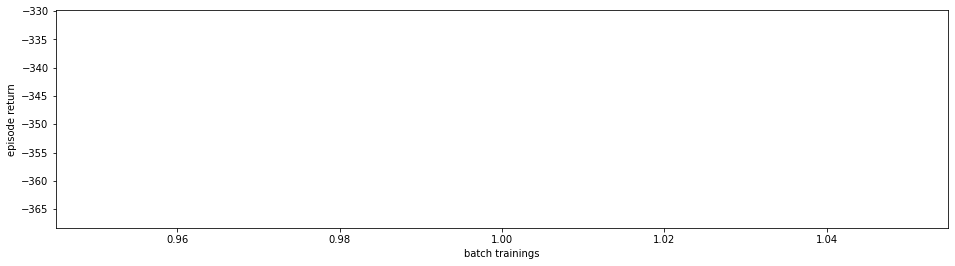

Batch 0 -349.1 +- 0


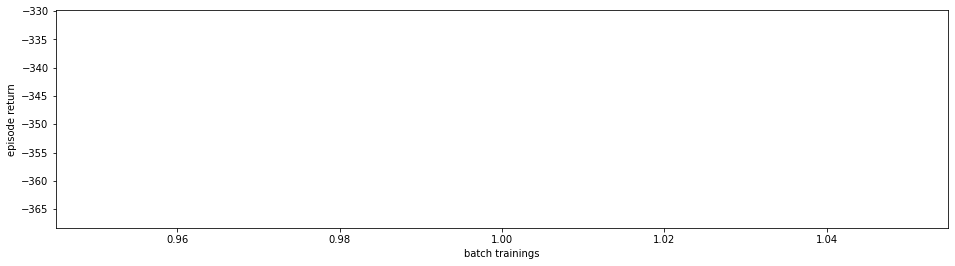

In [6]:
results = []
for epsilon in [1, 0.75, 0.5, 0.25, 0]:
    params = default_params()
    params['offpolicy_iterations'] = 128
    params['plot_train_samples'] = False
    params['plot_frequency'] = 4
    params['max_batch_episodes'] = int(1)
    params['batch_size'] = 4500
    params['epsilon_start'] = epsilon

    env = EnvWrapper(params.get('pref_pace'), params.get('target_pace'))
    n_actions, state_dim = params.get('num_actions'), params.get('states_shape')[0]
    # The model has n_action policy heads and one value head
    model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                             th.nn.Linear(128, 512), th.nn.ReLU(),
                             th.nn.Linear(512, 128), th.nn.ReLU(),
                             th.nn.Linear(128, n_actions + 1))
    experiment = ActorCriticExperimentRunning(params, model, learner=PPOLearner(model, params=params))
    # experiment = ActorCriticExperimentRunning(params, model, learner=OffpolicyActorCriticLearner(model, params=params))

    # Re-executing this code-block picks up the experiment where you left off
    experiment.run()
    # except KeyboardInterrupt:
    #     experiment.close()
    # experiment.plot_training()

    results = np.append(results, np.mean(experiment.episode_returns))

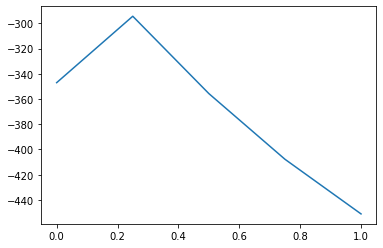

In [7]:
plt.plot([1, 0.75, 0.5, 0.25, 0], results)

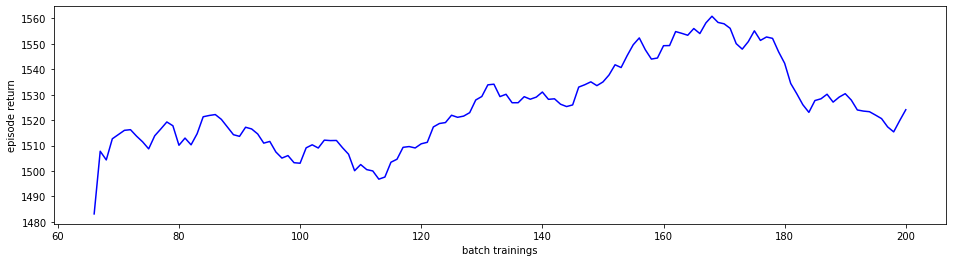

Batch 199 1492 +- 126
1512.104469356863


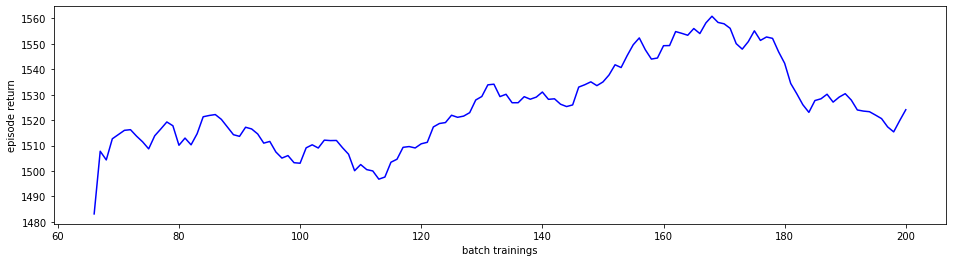

In [10]:

params = default_params()
params['offpolicy_iterations'] = 128
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['max_batch_episodes'] = int(200)
params['batch_size'] = 500
params['epsilon_start'] = 0.1

env = EnvWrapper(params.get('pref_pace'), params.get('target_pace'))
n_actions, state_dim = params.get('num_actions'), params.get('states_shape')[0]
# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 512), th.nn.ReLU(),
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperimentRunning(params, model, learner=PPOLearner(model, params=params))
# experiment = ActorCriticExperimentRunning(params, model, learner=OffpolicyActorCriticLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
experiment.run()
# except KeyboardInterrupt:
#     experiment.close()
# experiment.plot_training()

print(np.mean(experiment.episode_returns))

1387.4429127193448


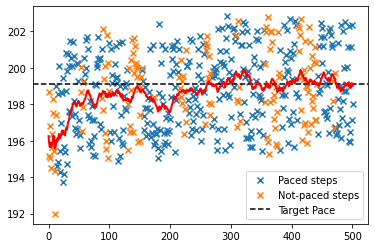

2220.0


In [9]:
test_in_environment(experiment, env)

In [10]:
episode_returns = []
episode_returns.append(experiment.test_in_env())
print(np.mean(episode_returns[-10:]))
print('Batch %.4g +- %.3g' % (np.mean(episode_returns[-10:]),
                                                     np.std(episode_returns[-10:])))

869.9581764974995
Batch 870 +- 664


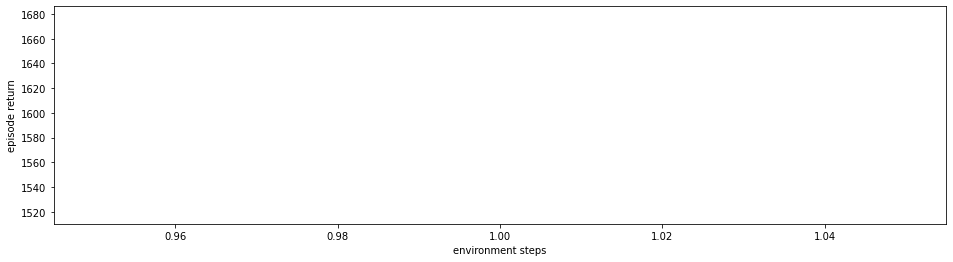

Batch 0 1598 +- 0


KeyboardInterrupt: 

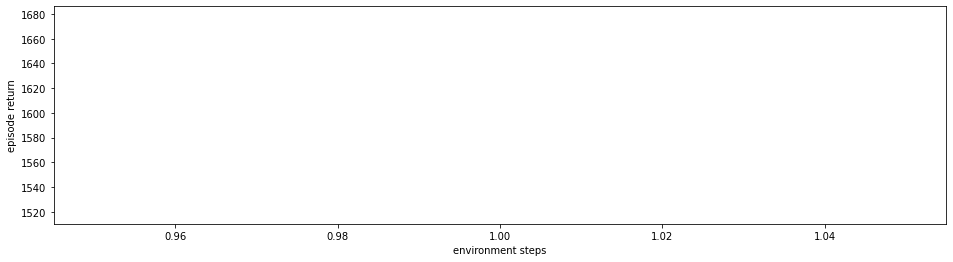

In [11]:
experiments = []
# off_policies = [256, 512, 1024, 2048, 4096]
off_policies = [256, 512, 1024]
# batches_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096]
batches_sizes = [32, 64, 128, 256]
max_batch_episodes = 4
epsilon_start = 0.1

for offpolicy_iterations in off_policies:
    for batch_size in batches_sizes:
        return_dict = {}
        params = default_params()
        params['offpolicy_iterations'] = offpolicy_iterations
        params['max_batch_episodes'] = max_batch_episodes
        params['epsilon_start'] = epsilon_start
        params['batch_size'] = batch_size

        env = EnvWrapper(params.get('pref_pace'), params.get('target_pace'))
        n_actions, state_dim = params.get('num_actions'), params.get('states_shape')[0]
        # The model has n_action policy heads and one value head
        model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                                 th.nn.Linear(128, 512), th.nn.ReLU(),
                                 th.nn.Linear(512, 128), th.nn.ReLU(),
                                 th.nn.Linear(128, n_actions + 1))
        experiment = ActorCriticExperimentRunning(params, model, learner=PPOLearner(model, params=params))
        # experiment = ActorCriticExperimentRunning(params, model, learner=OffpolicyActorCriticLearner(model, params=params))

        # Re-executing this code-block picks up the experiment where you left off
        experiment.run()

        return_dict.update({'model' : 'PPO',
                            'offpolicy_iterations': offpolicy_iterations,
                            'batch_size': batch_size,
                            'experiment': experiment})
        print('PPO-%d-%d'% (offpolicy_iterations, batch_size))
        experiments = np.append(experiments, return_dict)

for offpolicy_iterations in off_policies:
    for batch_size in batches_sizes:
        return_dict = {}
        params = default_params()
        params['offpolicy_iterations'] = offpolicy_iterations
        params['max_batch_episodes'] = max_batch_episodes
        params['epsilon_start'] = epsilon_start
        params['batch_size'] = batch_size

        env = EnvWrapper(params.get('pref_pace'), params.get('target_pace'))
        n_actions, state_dim = params.get('num_actions'), params.get('states_shape')[0]
        # The model has n_action policy heads and one value head
        model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                                 th.nn.Linear(128, 512), th.nn.ReLU(),
                                 th.nn.Linear(512, 128), th.nn.ReLU(),
                                 th.nn.Linear(128, n_actions + 1))
        # experiment = ActorCriticExperimentRunning(params, model, learner=PPOLearner(model, params=params))
        experiment = ActorCriticExperimentRunning(params, model, learner=OffpolicyActorCriticLearner(model, params=params))

        # Re-executing this code-block picks up the experiment where you left off
        experiment.run()

        return_dict.update({'model' : 'Off-PAC',
                            'offpolicy_iterations': offpolicy_iterations,
                            'batch_size': batch_size,
                            'experiment': experiment})
        print('Off-PAC-%d-%d'% (offpolicy_iterations, batch_size))
        experiments = np.append(experiments, return_dict)

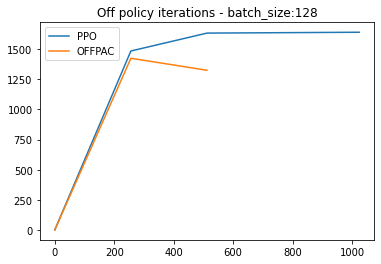

In [17]:
batch_size = 128
plt.title('Off policy iterations - batch_size:%d' % batch_size)
PPO = [[0, 0]]
OFFPAC = [[0, 0]]
for exp in experiments:
    if exp['batch_size'] == batch_size:
        if exp['model'] == 'PPO':
            PPO = np.concatenate((PPO, [[exp['offpolicy_iterations'], np.mean(exp['experiment'].episode_returns)]]))
        if exp['model'] == 'Off-PAC':
            OFFPAC = np.concatenate((OFFPAC, [[exp['offpolicy_iterations'], np.mean(exp['experiment'].episode_returns)]]))
PPO = np.transpose(PPO)
OFFPAC = np.transpose(OFFPAC)
plt.plot(PPO[0], PPO[1], label='PPO')
plt.plot(OFFPAC[0], OFFPAC[1], label='OFFPAC')
plt.legend()


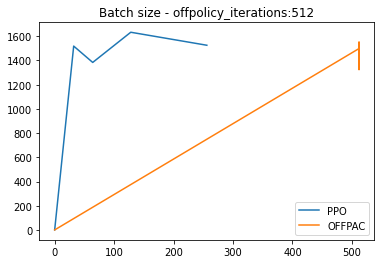

In [19]:
offpolicy_iterations = 512
plt.title('Batch size - offpolicy_iterations:%d' % offpolicy_iterations)
PPO = [[0, 0]]
OFFPAC = [[0, 0]]
for exp in experiments:
    if exp['offpolicy_iterations'] == offpolicy_iterations:
        if exp['model'] == 'PPO':
            PPO = np.concatenate((PPO, [[exp['batch_size'], np.mean(exp['experiment'].episode_returns)]]))
        if exp['model'] == 'Off-PAC':
            OFFPAC = np.concatenate((OFFPAC, [[exp['offpolicy_iterations'], np.mean(exp['experiment'].episode_returns)]]))
PPO = np.transpose(PPO)
OFFPAC = np.transpose(OFFPAC)
plt.plot(PPO[0], PPO[1], label='PPO')
plt.plot(OFFPAC[0], OFFPAC[1], label='OFFPAC')
plt.legend()

In [14]:
results = []
for exp in experiments:
    model = 0
    if exp['model'] == 'PPO':
        model = 1
    results.append([model, exp['batch_size'],exp['offpolicy_iterations'], np.mean(exp['experiment'].episode_returns)])
    if np.mean(exp['experiment'].episode_returns) > 0:
        print(exp['model'],exp['batch_size'],exp['offpolicy_iterations'], np.mean(exp['experiment'].episode_returns))
np.savetxt("off-policy-parameters.csv", results, header="model,batch_size, offpolicy_iterations, avg_result", delimiter=",")

PPO 64 256 116.40671462155655
PPO 64 512 947.5747029514899
PPO 32 1024 332.84147403442745
Off-PAC 1024 512 752.7509756156763
